In [67]:
import torch 
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../../data/names.txt','r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {char:i for i,char in enumerate(chars)}
stoi['.'] = 0 
itos = {i:char for char,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
27


In [4]:
def build_dataset(words): 
    block_size = 3
    X, Y = [], []
    for w in words: 
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [135]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train , Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [129]:
def compare(s, dt, t): 
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')



In [136]:
n_embd = 10 
n_hidden = 64
block_size = 3

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # Don't need this becasue of batchnorm

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1# initalized not to zero because it unmasks potential dead neurons

# Batchnorm
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 +1
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1


params = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in params))
for p in params: 
    p.requires_grad = True

4137


In [137]:
batch_size = 32
n = batch_size 

# Mini-batch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [138]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()



In [139]:
for p in params:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.4007, grad_fn=<NegBackward0>)

In [140]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T # Need to be Matrix Multiplication and this is the only way the shapes work
dW2 = h.T @ dlogits # Same here, there is only one way to make the shapes work
db2 = dlogits.sum(0) 
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += 1/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dC[ix] += demb[k, j]
    

compare('logprobs', dlogprobs, logprobs)
compare('probs', dprobs, probs)
compare('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare('counts_sum', dcounts_sum, counts_sum)
compare('counts', dcounts, counts)
compare('norm_logits', dnorm_logits, norm_logits)
compare('logit_maxes', dlogit_maxes, logit_maxes)
compare('logits', dlogits, logits)
compare('h', dh, h)
compare('W2', dW2, W2)
compare('b2', db2, b2)
compare('hpreact', dhpreact, hpreact)
compare('bngain', dbngain, bngain)
compare('bnbias', dbnbias, bnbias)
compare('bnraw', dbnraw, bnraw)
compare('bnvar_inv', dbnvar_inv, bnvar_inv)
compare('bnvar', dbnvar, bnvar)
compare('bndiff2', dbndiff2, bndiff2)
compare('bndiff', dbndiff, bndiff)
compare('bnmeani', dbnmeani, bnmeani)
compare('hprebn', dhprebn, hprebn)
compare('embcat', dembcat, embcat)
compare('W1', dW1, W1)
compare('b1', db1, b1)
compare('emb', demb, emb)
compare('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [141]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff' , (loss_fast - loss).item())

3.40073561668396 diff 0.0


In [142]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

compare('logits', dlogits, logits)


logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


In [143]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [144]:
F.softmax(logits, 1)[0]

tensor([0.0218, 0.1236, 0.0193, 0.0556, 0.0285, 0.0637, 0.0446, 0.0165, 0.0275,
        0.0271, 0.0124, 0.0636, 0.0265, 0.0240, 0.0330, 0.0272, 0.0245, 0.0388,
        0.0402, 0.0900, 0.0348, 0.0130, 0.0327, 0.0154, 0.0103, 0.0171, 0.0682],
       grad_fn=<SelectBackward0>)

In [146]:
dlogits[0] * n 

tensor([ 0.0218,  0.1236,  0.0193,  0.0556,  0.0285,  0.0637,  0.0446,  0.0165,
         0.0275,  0.0271,  0.0124,  0.0636,  0.0265,  0.0240,  0.0330,  0.0272,
         0.0245,  0.0388,  0.0402, -0.9100,  0.0348,  0.0130,  0.0327,  0.0154,
         0.0103,  0.0171,  0.0682], grad_fn=<MulBackward0>)

In [147]:
dlogits[0].sum()

tensor(3.9581e-09, grad_fn=<SumBackward0>)

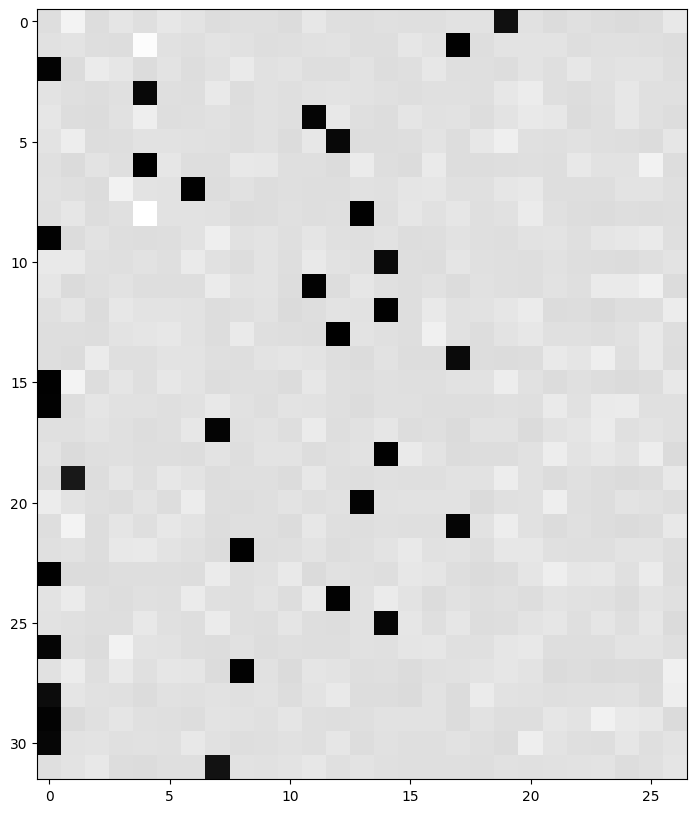

In [149]:
plt.figure(figsize=(10, 10))
plt.imshow(dlogits.detach(), cmap='gray')

In [150]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [152]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

compare('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [154]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(42)  
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1

params = [C, W1, b1, W2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True
    
batch_size = 32
n = batch_size
n_steps = 10000

loss_i = []

for step in range(n_steps):
    
    # Mini-batch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer 1
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    
    # BatchNorm layer
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    
    #loss.backward() # for corrrness check
    
    # Manual backward pass  
    
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # Layer 2 backward
    
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dh = dlogits @ W2.T
    
    # Non-linearity backward
    dhpreact = (1 - h**2) * dh
    # BatchNorm backward
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)  
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # Layer 1 backward
    dW1 = embcat.T @ dhprebn
    dembcat = dhprebn @ W1.T
    db1 = dhprebn.sum(0)
    
    # Embedding backward
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k, j]
            dC[ix] += demb[k, j]
    
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    
    lf = 0.1 if step < 5000 else 0.01 
    for p, d in zip(params, grads):
        p.data += -lf * d
        
    
    if step % 1000 == 0:
        loss_i.append(loss.item())
        print(f'step: {step}, loss: {loss.item()}')
    
    


step: 0, loss: 3.40073561668396
step: 1000, loss: 2.765106439590454
step: 2000, loss: 2.5726866722106934
step: 3000, loss: 2.3145179748535156
step: 4000, loss: 2.0860652923583984
step: 5000, loss: 2.0322234630584717
step: 6000, loss: 2.264892816543579
step: 7000, loss: 2.305232048034668
step: 8000, loss: 2.5049843788146973
step: 9000, loss: 2.223799467086792


In [155]:
with torch.no_grad(): 
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    hprebn = embcat @ W1 + b1
    
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)

In [156]:
@torch.no_grad()

def split_loss(split): 
    x, y  = {'train': (X_train, Y_train), 'val': (X_val, Y_val), 'test': (X_test, Y_test)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hprebn = embcat @ W1 + b1
    
    hpreact = bngain * (hprebn - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')
    

train loss: 2.2138736248016357
val loss: 2.2178831100463867


In [157]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

nur.
khni.
kilen.
noe.
sinn.
riensth.
kesmer.
.
rislen.
mi.
k.
nz.
kel.
.
liy.
mrosy.
s.
leullyinlyn.
o.
tiec.
